In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.applications.xception import Xception
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential, Model,load_model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import TensorBoard

%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, name='fc1')(x)
x = Dropout(0.2)(x)
x = Dense(4096, name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model_final = Model(inputs=base_model.input, outputs=x)
#model_final.compile(loss="categorical_crossentropy", optimizer=optimizers.sgd(lr=0.0001, momentum=0.9), metrics=["accuracy"])
model_final.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=0.00001), metrics=["accuracy"])
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
weights_file = 'vgg16_clothing_classifier_0911_v1.h5'
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range =.2,
                                  zoom_range = .2,
                                  horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_data_dir = 'data/train'
validation_data_dir = "data/test"
nb_validation_samples = 10000
nb_train_samples = 40000
epochs = 15
batch_size = 10
img_width, img_height = 224, 224

train_generator = train_datagen.flow_from_directory(
                train_data_dir,
                target_size=(img_width, img_height),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

val_generator = val_datagen.flow_from_directory(
                                validation_data_dir,
                                target_size = (img_height, img_width),
                                batch_size=batch_size,
                                class_mode = "categorical")

checkpoint = ModelCheckpoint(weights_file, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

Found 51376 images belonging to 11 classes.
Found 10022 images belonging to 10 classes.


In [7]:
train_generator.class_indices

{'.ipynb_checkpoints': 0,
 'dress': 1,
 'jacket': 2,
 'jeans': 3,
 'outerwear': 4,
 'pants': 5,
 'shorts': 6,
 'skirts': 7,
 'sweaters': 8,
 'sweatshirt': 9,
 'tops': 10}

In [ ]:
# Train the model 
history = model_final.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=nb_validation_samples//batch_size,
            verbose=1,
            workers=4, 
            callbacks = [checkpoint, early,tensorboard])

Epoch 1/15
4000/4000 [==============================] - 220s 55ms/step - loss: 0.9102 - acc: 0.6942 - val_loss: 0.7563 - val_acc: 0.7400

Epoch 00001: val_acc improved from -inf to 0.73997, saving model to vgg16_clothing_classifier_0911_v1.h5
Epoch 2/15
4000/4000 [==============================] - 218s 55ms/step - loss: 0.7013 - acc: 0.7614 - val_loss: 0.7949 - val_acc: 0.7400

Epoch 00002: val_acc improved from 0.73997 to 0.73997, saving model to vgg16_clothing_classifier_0911_v1.h5
Epoch 3/15
4000/4000 [==============================] - 219s 55ms/step - loss: 0.6506 - acc: 0.7777 - val_loss: 0.7894 - val_acc: 0.7428

Epoch 00003: val_acc improved from 0.73997 to 0.74277, saving model to vgg16_clothing_classifier_0911_v1.h5
Epoch 4/15
4000/4000 [==============================] - 217s 54ms/step - loss: 0.6186 - acc: 0.7927 - val_loss: 0.7469 - val_acc: 0.7636

Epoch 00004: val_acc improved from 0.74277 to 0.76362, saving model to vgg16_clothing_classifier_0911_v1.h5
Epoch 5/15
4000/400

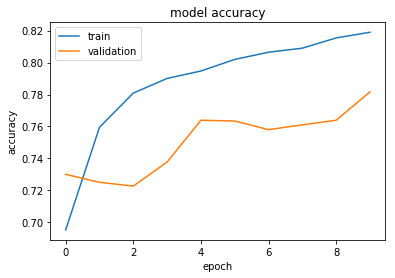

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_15.png', dpi=500);

In [9]:
model_final.save('vgg16_clothing_classifier_0909.h5')

In [9]:
from keras.models import model_from_json
json_string = model_final.to_json()

with open("vgg16_0905.json", 'w') as json_file:
        json_file.write(json_string)

In [11]:
model_final.save('vgg16_clothing_classifier_0905_all.h5')